# TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION

- [pytorch_official](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)
- [colab](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/seq2seq_translation_tutorial.ipynb#scrollTo=HSoju4kDvdFn)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from smutil import *

In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Reproducibility

In [5]:
SEED = 2019

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Loading Data Files

In [6]:
dirName = '../data'
dirModel = "../model"

In [7]:
if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists")

Directory  ../data  already exists


In [8]:
if not os.path.exists(dirModel):
    os.mkdir(dirModel)
    print("Directory " , dirModel ,  " Created ")
else:    
    print("Directory " , dirModel ,  " already exists")

Directory  ../model  already exists


In [9]:
#!wget https://download.pytorch.org/tutorial/data.zip

In [10]:
#!unzip data.zip

In [11]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [12]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [16]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [17]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [18]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['je meurs de soif .', 'i m very thirsty .']


## The Encoder

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## The Decoder

In [20]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Attention

In [21]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Preparing Training Data

In [22]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## Train the model

In [23]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.

In [24]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s \t(%d %d%%)\t%.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [25]:
import matplotlib.ticker as ticker
def showPlot(points):
    with mpl.style.context('seaborn-talk'):
        fig = plt.figure(figsize=(5,4))
        plt.plot(points, color='b', alpha=0.5, label='loss')
        plt.title("Loss vs Epoch",fontweight="bold")
        plt.xlabel("Epoch",fontweight="bold")
        plt.ylabel("Loss",fontweight="bold")
        plt.grid(color='gray', alpha=0.2)
        plt.legend()
        plt.show()

## Evaluation

In [26]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

### Evaluate Random Sentence

In [27]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Train Util

0m 1s (- 0m 27s) 	(20 5%)	6.2570
0m 2s (- 0m 25s) 	(40 10%)	4.6465
0m 4s (- 0m 23s) 	(60 15%)	3.9600
0m 5s (- 0m 23s) 	(80 20%)	4.0494
0m 7s (- 0m 22s) 	(100 25%)	3.6492
0m 8s (- 0m 20s) 	(120 30%)	3.5842
0m 10s (- 0m 19s) 	(140 35%)	3.7180
0m 11s (- 0m 17s) 	(160 40%)	3.6912
0m 13s (- 0m 16s) 	(180 45%)	3.4424
0m 14s (- 0m 14s) 	(200 50%)	3.3436
0m 16s (- 0m 13s) 	(220 55%)	3.2154
0m 18s (- 0m 12s) 	(240 60%)	3.6692
0m 19s (- 0m 10s) 	(260 65%)	3.5965
0m 21s (- 0m 9s) 	(280 70%)	3.4802
0m 22s (- 0m 7s) 	(300 75%)	3.8842
0m 24s (- 0m 6s) 	(320 80%)	3.3834
0m 26s (- 0m 4s) 	(340 85%)	3.6102
0m 27s (- 0m 3s) 	(360 90%)	3.4090
0m 29s (- 0m 1s) 	(380 95%)	3.5025
0m 30s (- 0m 0s) 	(400 100%)	3.7851


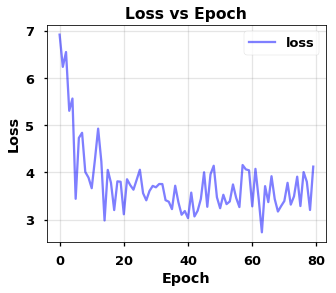

In [29]:
warnings.filterwarnings('ignore')
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, n_iters=400, print_every=20, plot_every=5)

## Visualize Attention

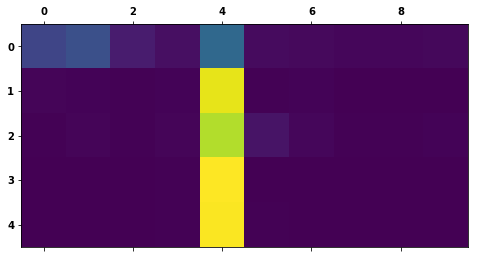

In [30]:
output_words, attentions = evaluate(encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy()) #,cmap='bone'
#sns.heatmap(attentions.numpy())

In [31]:
#attentions.numpy()

input = elle a cinq ans de moins que moi .
output = i m not . <EOS>


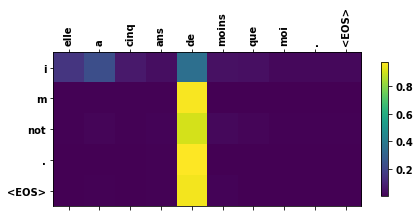

input = elle est trop petit .
output = i m not . <EOS>


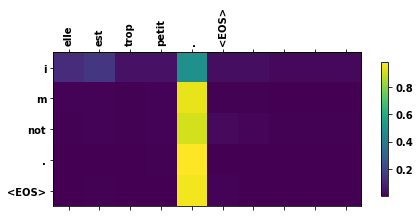

input = je ne crains pas de mourir .
output = i m not . <EOS>


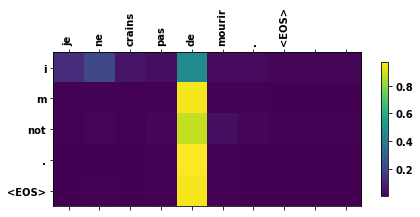

input = c est un jeune directeur plein de talent .
output = i m not . <EOS>


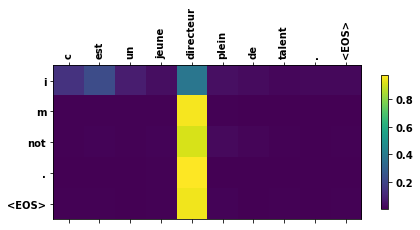

In [32]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy())
    fig.colorbar(cax, fraction=0.02, pad=0.06)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

## Save the model

- [pytorch model saving](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
- [os_path_join](https://www.bogotobogo.com/python/python_files.php)

In [33]:
# encoder1, attn_decoder1
file_encoder = "encoder.pt"
file_decoder = "attn_decoder.pt"

In [34]:
print(os.path.join(dirModel, file_encoder))

../model/encoder.pt


In [35]:
torch.save(encoder1.state_dict(),os.path.join(dirModel, file_encoder))

In [36]:
torch.save(attn_decoder1.state_dict(),os.path.join(dirModel, file_decoder))

## Load the model and Evaluate

> Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

- [pytorch model loading](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Loading Encoder

In [37]:
model_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
model_encoder.load_state_dict(torch.load(os.path.join(dirModel, file_encoder)))
model_encoder.eval()

EncoderRNN(
  (embedding): Embedding(4489, 256)
  (gru): GRU(256, 256)
)

### Loading Decoder

In [38]:
model_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
model_decoder.load_state_dict(torch.load(os.path.join(dirModel, file_decoder)))
model_decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(2925, 256)
  (attn): Linear(in_features=512, out_features=10, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=2925, bias=True)
)

## Predict

In [39]:
def predict(input_sentence, encoder, decoder):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = elle a cinq ans de moins que moi .
output = i m not . <EOS>


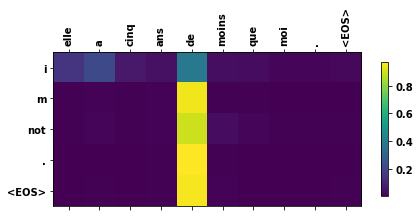

In [40]:
sent = "elle a cinq ans de moins que moi ."
predict(sent, model_encoder, model_decoder)

input = elle a cinq ans de moins que moi .
output = i m not . <EOS>


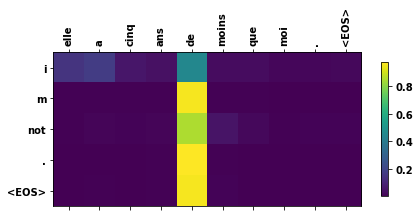

In [41]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")